In [32]:
from typing import List, Callable, Dict, Any, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor

from find_my_bike.dataset import EbayDataModule, EbayDataset

In [33]:
def calculate_status(dataset: EbayDataset, callbacks: List[Callable]) -> Dict[str, List[Any]]:
    for image, labels in dataset:
        for callback in callbacks:
            callback(image, labels)

    status = {}
    for callback in callbacks:
        status.update(callback.calc())

    return status

In [34]:
class AspectHistogramCallback:
    def __init__(self, aspects: List[str], normalized: bool = True) -> None:
        self.aspects = aspects
        self.normalized = normalized

        self._aspect_labels = {aspect: [] for aspect in self.aspects}

    def __call__(self, image: torch.Tensor, labels: torch.Tensor) -> None:
        for i, aspect in enumerate(self.aspects):
            self._aspect_labels[aspect].append(labels[i].item())

    def calc(self) -> Dict[str, np.ndarray]:
        aspect_status = {}
        for aspect, values in self._aspect_labels.items():
            num_classes = len(np.unique(values))
            bins = np.arange(0, num_classes + 0.5) - 0.5
            aspect_status[aspect], _ = np.histogram(values, bins, density=self.normalized)

        return aspect_status

class ImageShapeCallback:
    def __init__(self) -> None:
        self._channels = []
        self._height = []
        self._width = []

    def __call__(self, image: torch.Tensor, labels: torch.Tensor) -> None:
        self._channels.append(image.shape[0])
        self._height.append(image.shape[1])
        self._width.append(image.shape[2])

    def calc(self) -> Dict[str, Tuple[np.ndarray, np.ndarray]]:
        return {"channels": np.histogram(self._channels), "height": np.histogram(self._height), "width": np.histogram(self._width)}

In [45]:
def hist(counts, bins):
    centroids = (bins[1:] + bins[:-1]) / 2
    plt.hist(centroids, bins=len(counts), weights=counts, range=(min(bins), max(bins)))

def aspect_bars(train, val, aspect):
    plt.bar(np.arange(len(train[aspect])), train[aspect], width=0.4, label="Train")
    plt.bar(np.arange(len(val[aspect])) + 0.4, val[aspect], width = 0.4, label="Val")
    plt.xticks(np.arange(0.2, 4.2), dm.train_data.class_names[aspect])
    plt.legend()

In [36]:
dm = EbayDataModule("/home/tilman/Programming/find-my-bike/data/ebay", aspects=["bike"], training_transforms=ToTensor(), batch_size=64)
train_status = calculate_status(dm.train_data, [AspectHistogramCallback(["bike"]), ImageShapeCallback()])
val_status = calculate_status(dm.val_data, [AspectHistogramCallback(["bike"])])

# Aspects
## Bike

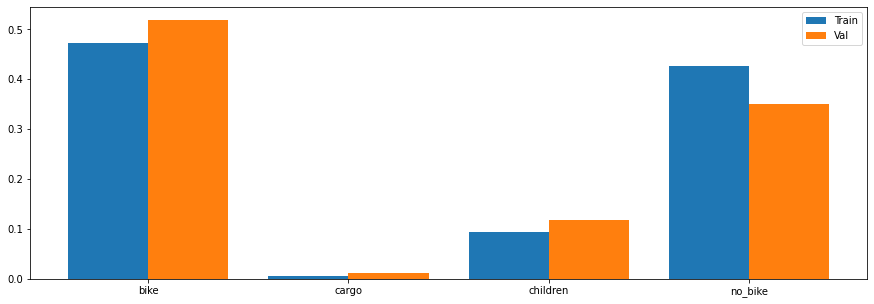

In [46]:
plt.figure(figsize=(15, 5))
aspect_bars(train_status, val_status, "bike")

# Image Shapes
## Channels

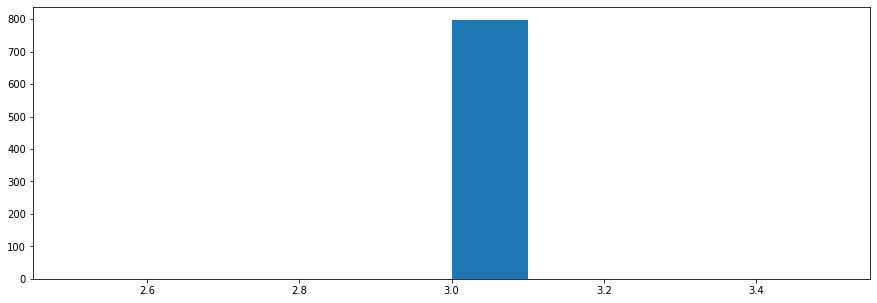

In [42]:
plt.figure(figsize=(15, 5))
hist(*train_status["channels"])

## Height

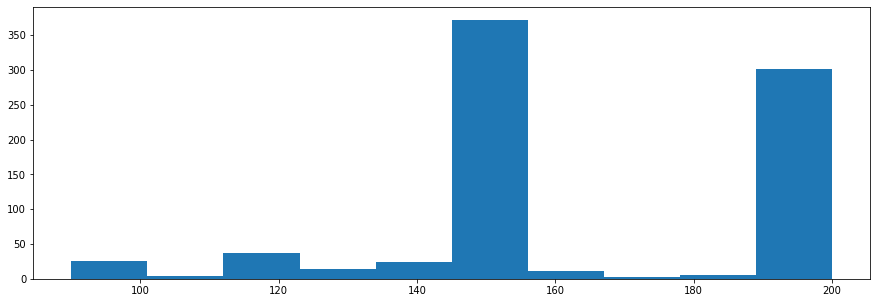

In [43]:
plt.figure(figsize=(15, 5))
hist(*train_status["height"])

## Width

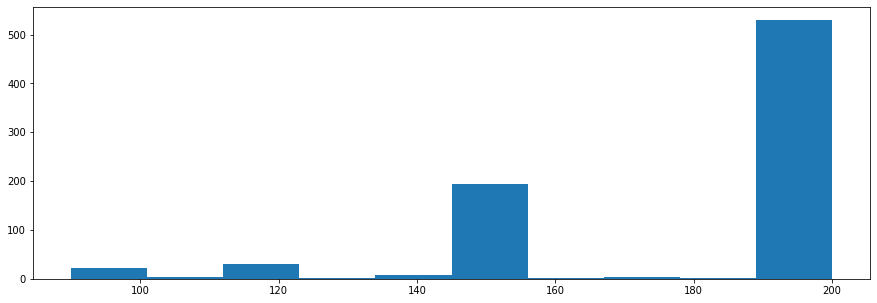

In [44]:
plt.figure(figsize=(15, 5))
hist(*train_status["width"])